 ##   INCIDENT MANAGEMENT  PROCESS IMPROVEMENT        

In [318]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
%matplotlib inline
sns.set()
from pandas_profiling import ProfileReport
sns.set(style='ticks', context='notebook')
sns.set(font_scale=3.0)
plt.rcParams['figure.figsize'] = [30, 25]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams["axes.labelsize"] = 30

In [319]:
#Loading data
file = 'incident_event_log.csv'
inc_event = pd.read_csv(file)


In [320]:
#coverting this data to a panda dataframe for further data wrangling

inc_eventdf = pd.DataFrame(inc_event)
pd.options.display.max_columns = None

In [321]:
#to replace missing value symbol '?' to NaN
inc_eventdf = inc_eventdf.replace(to_replace=['?'],value = [np.nan]) 

In [322]:
col_name = ['sys_created_at','opened_at','sys_updated_at','resolved_at','closed_at']
for i in range(len(col_name)):
    inc_eventdf[col_name[i]] = pd.to_datetime(inc_eventdf[col_name[i]], dayfirst = True)

In [323]:
# filling all the missing value in resolved_at colums with information in sys_updated_at
# sys_updated_at time corresponding to 'Resolved' state in incident_state
# and using ffill to fill the missing value where the incident_state is 'Closed'

m = inc_eventdf.incident_state == 'Resolved'
y = inc_eventdf.resolved_at.isnull()
c =inc_eventdf.incident_state == 'Closed'
inc_eventdf['resolved_at'] = np.where(m & y,inc_eventdf['sys_updated_at'],inc_eventdf['resolved_at'])
inc_eventdf['resolved_at']= np.where(c & y,inc_eventdf['resolved_at'].ffill(axis=0),inc_eventdf['resolved_at'])

In [324]:
# Dropping all the rows where above trick did not resolve the “resolved_at” missing issue 
# Creating two diffrent list for collecting index information for where "incident_state" is '-100'
# And "resolved_at" is null then using for loop to add them in inc_remove and then droping them.

drop_index1 = inc_eventdf[inc_eventdf['incident_state']== '-100'].number.value_counts().index
drop_index = inc_eventdf[inc_eventdf.resolved_at.isnull()].number.value_counts().index
inc_remove = []

for i,j in enumerate(drop_index1):
    inc_name = inc_eventdf.loc[inc_event.number == j].index
    inc_remove.extend(inc_name)
    
    
for i,j in enumerate(drop_index):
    inc_name = inc_eventdf.loc[inc_event.number == j].index
    inc_remove.extend(inc_name)    
    
inc_eventdf = inc_eventdf.drop(inc_eventdf.loc[inc_remove].index) 
inc_eventdf.reset_index(inplace= True)
inc_eventdf.drop(['index'],axis=1,inplace=True)


In [325]:
#replacing all the NaN value in other columns to "N/A"
empty_col = []
for col in inc_eventdf.columns:
    x= inc_eventdf[col].isnull().value_counts().values
    if x[0] < 141658:
        inc_eventdf[col].fillna("N/A",inplace=True)

In [326]:
def min_conv(x,y,z,data=inc_eventdf):
    data["days"] = ((data[x] - data[y])).dt.days
    data['seconds'] = ((data[x] - data[y])).dt.seconds
    data[z] = ((data['days']*24*60))+(data['seconds']/60)
    data[z] = data[z].astype('int64')
    data = data.drop([x,"days",'seconds'],axis=1,inplace=True)

In [327]:
#adding total time to close : Closing time (min)
#adding total time to resolve : resolving time (min)
#adding time since ticket is opened : time_tillnow
#adding time till tickt is closed: time_elapsed

min_conv('closed_at','opened_at','Closing time (min)')
min_conv('sys_updated_at','opened_at','time_tillnow')
inc_eventdf['time_elapsed'] =inc_eventdf['Closing time (min)'] - inc_eventdf['time_tillnow']
inc_eventdf['time_elapsed'] = inc_eventdf['time_elapsed'].astype('int64')

In [328]:
inc_original = inc_eventdf.copy()

## Dataset reset point

In [329]:
inc_eventdf = inc_original.copy()

In [330]:
remove = ['caller_id','opened_by','sys_created_by','sys_created_at','sys_updated_by','resolved_by','time_tillnow']
inc_eventdf = inc_eventdf.drop(remove,axis=1)

In [331]:
inc_backup = inc_eventdf.copy()

## Creating two separate set for data exploration

In [332]:
# As Closed is the last stage of the ticket filtering the dataset for just the incident_state 'Closed'
# The number of the unique incident is 24918 and this is more than that there is must be more dublicate incidents 
# For the sake of this project we need the last stage of the ticket hence selecting the last duplicate and reindexing for further use


inc_closed = inc_eventdf.loc[inc_eventdf['incident_state'] == 'Closed', :].copy()
inc_closed.drop_duplicates(subset = 'number',keep='last',inplace = True)
inc_closed = inc_closed.drop(['time_elapsed'],axis=1)
inc_closed.reset_index(inplace = True)
inc_closed.drop(['index'], axis=1,inplace = True)


In [333]:
inc_closed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24902 entries, 0 to 24901
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   number                   24902 non-null  object        
 1   incident_state           24902 non-null  object        
 2   active                   24902 non-null  bool          
 3   reassignment_count       24902 non-null  int64         
 4   reopen_count             24902 non-null  int64         
 5   sys_mod_count            24902 non-null  int64         
 6   made_sla                 24902 non-null  bool          
 7   opened_at                24902 non-null  datetime64[ns]
 8   contact_type             24902 non-null  object        
 9   location                 24902 non-null  object        
 10  category                 24902 non-null  object        
 11  subcategory              24902 non-null  object        
 12  u_symptom                24902 n

In [334]:
inc_eventdf = inc_eventdf.drop(['Closing time (min)'],axis=1)

In [335]:
inc_eventdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141658 entries, 0 to 141657
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   number                   141658 non-null  object        
 1   incident_state           141658 non-null  object        
 2   active                   141658 non-null  bool          
 3   reassignment_count       141658 non-null  int64         
 4   reopen_count             141658 non-null  int64         
 5   sys_mod_count            141658 non-null  int64         
 6   made_sla                 141658 non-null  bool          
 7   opened_at                141658 non-null  datetime64[ns]
 8   contact_type             141658 non-null  object        
 9   location                 141658 non-null  object        
 10  category                 141658 non-null  object        
 11  subcategory              141658 non-null  object        
 12  u_symptom       

### Function for adding percetage on barchart


In [336]:
def bar_perc(ax):
    
   
    totals = [] #create a empty list
    
    for i in ax.patches:             #ax.patches to select each bar as a rectangle
        totals.append(i.get_height()) # .get_height() is used for vertical bar chart use .get_width() for horizontal()
    
    
    total = sum(totals) # for geting total no of elements with height as proxy
    
    
    for i in ax.patches:
        ax.text(i.get_x()+0.15, i.get_height()+100, \
            str(round((i.get_height()/total)*100, 2))+'%',color='black')

# .get_x() gets the starting x-axis and for y-axis use .get_height

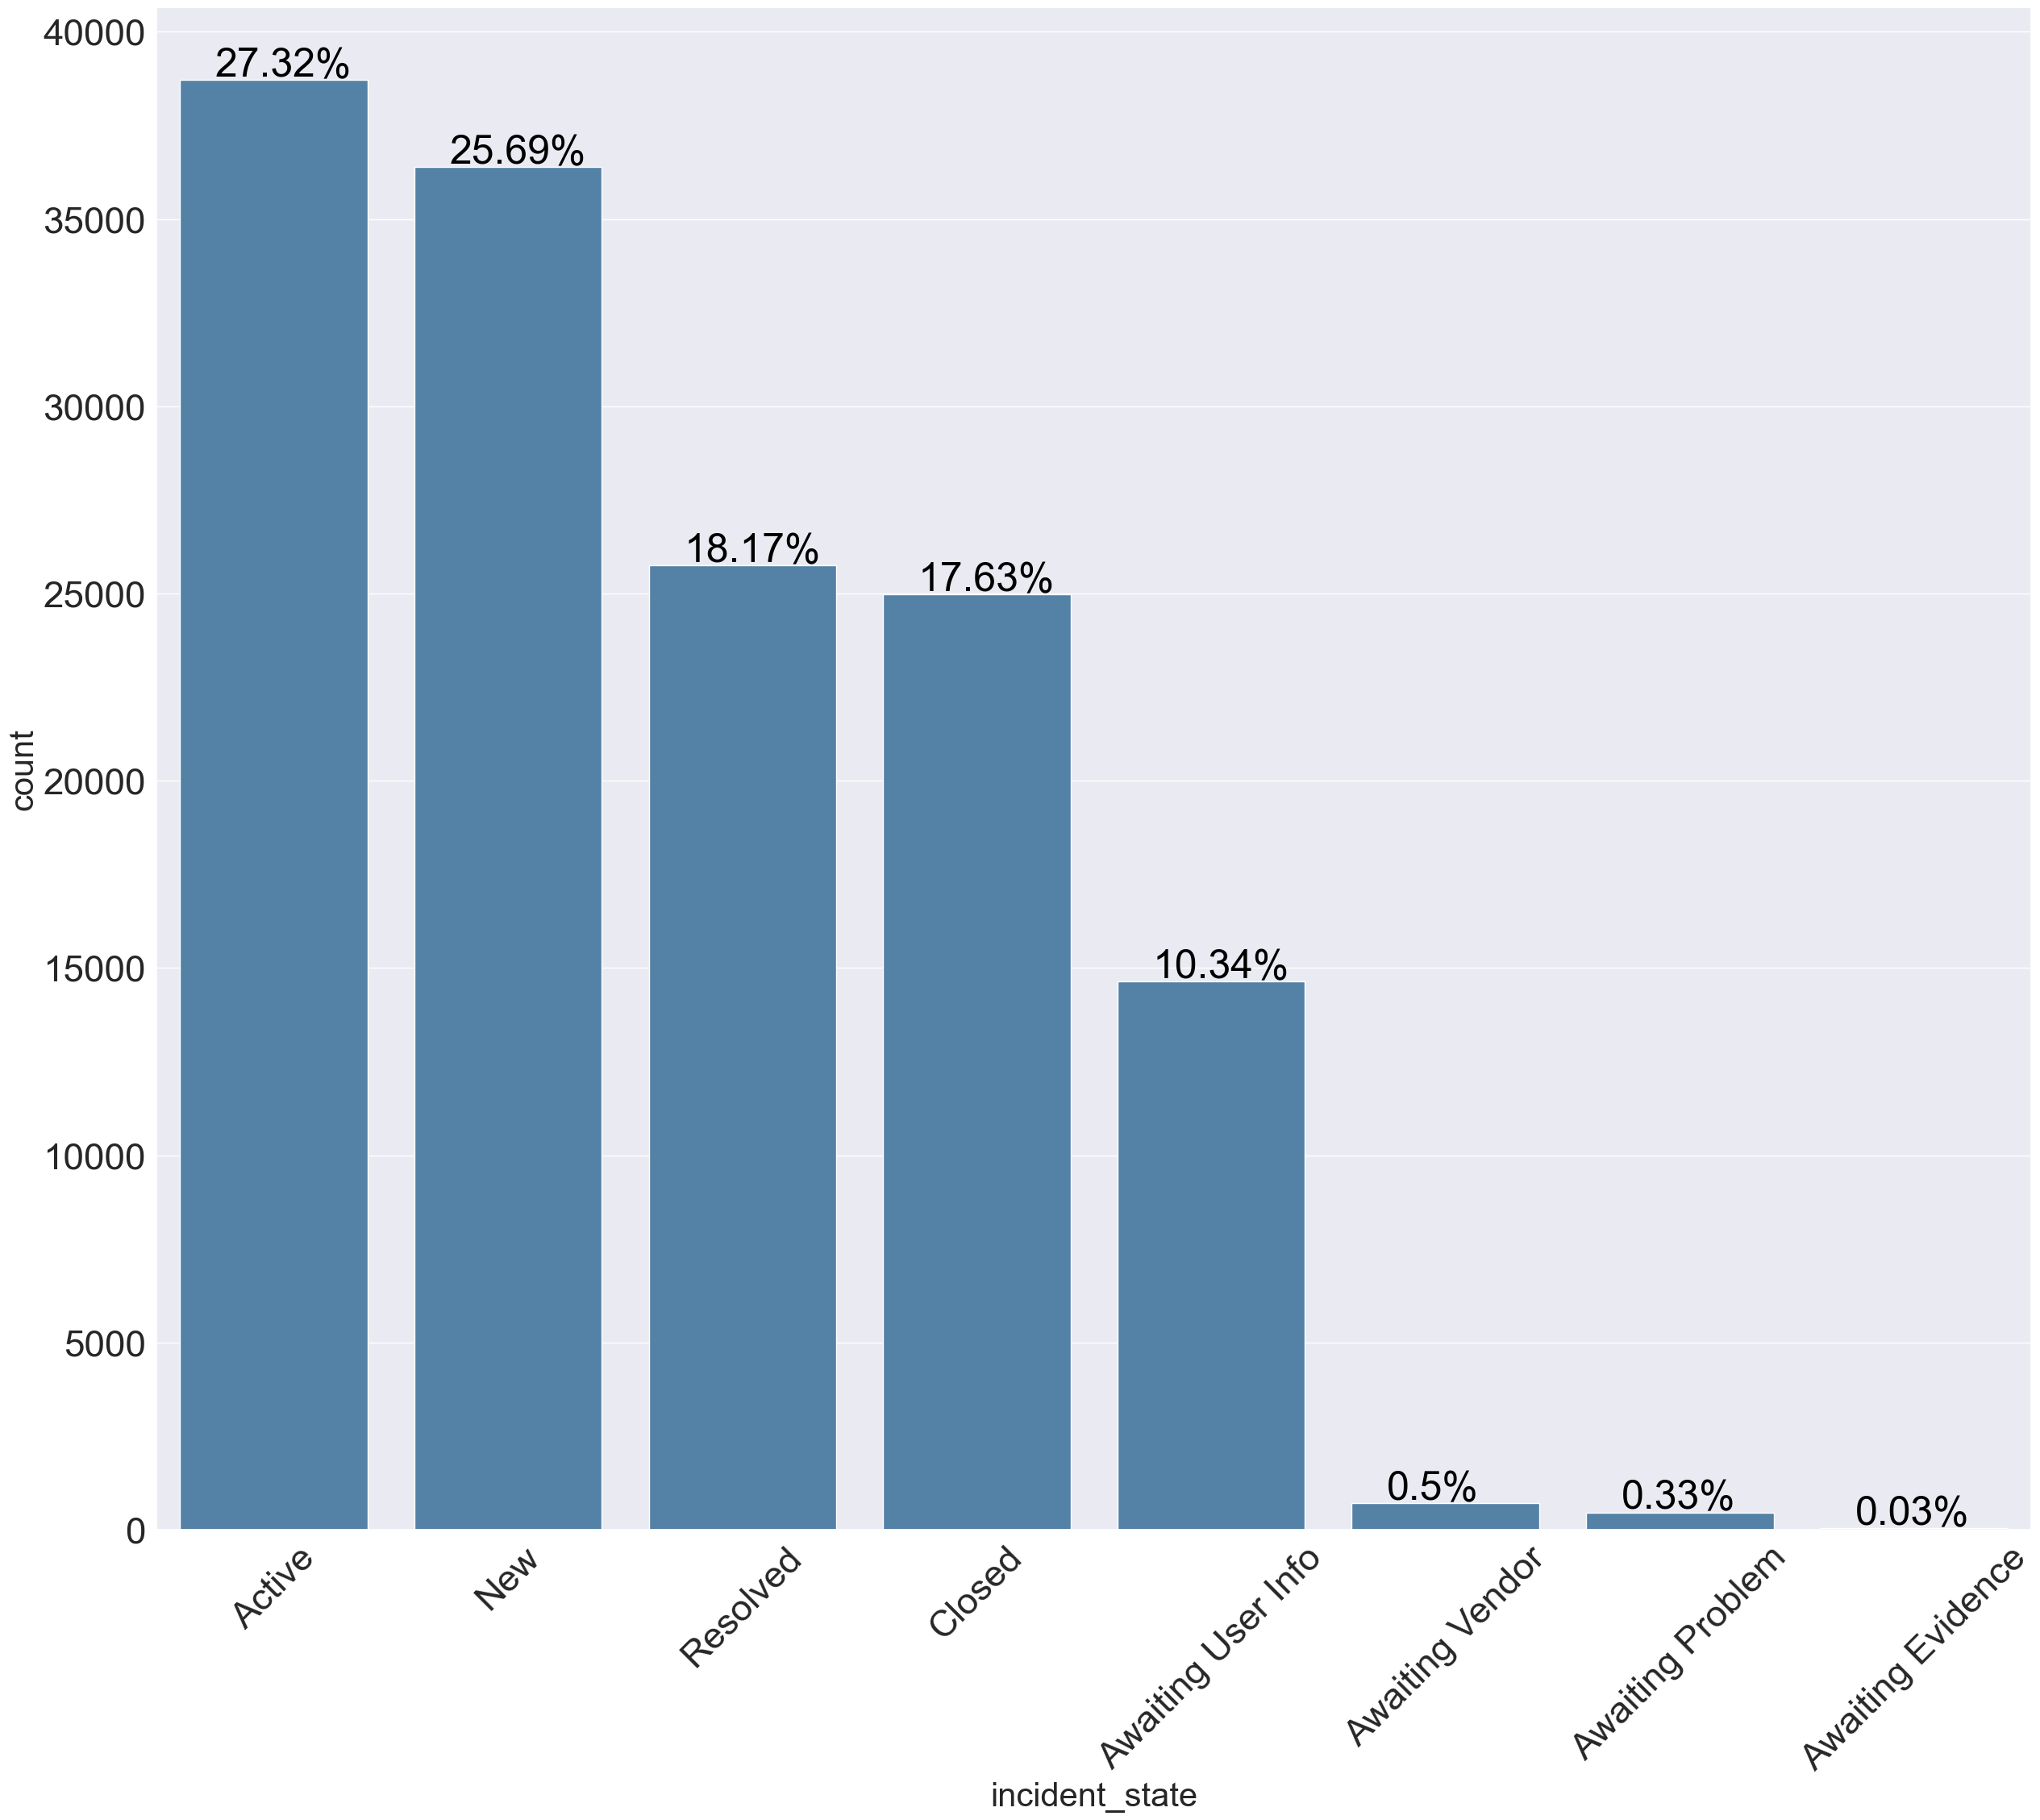

In [337]:
ascending_order = inc_eventdf['incident_state'].value_counts().sort_values(ascending=False).index
plot1 =sns.countplot(data = inc_eventdf, x = 'incident_state',order = ascending_order,color= "steelblue")
plt.xticks(rotation=45)
bar_perc(plot1)

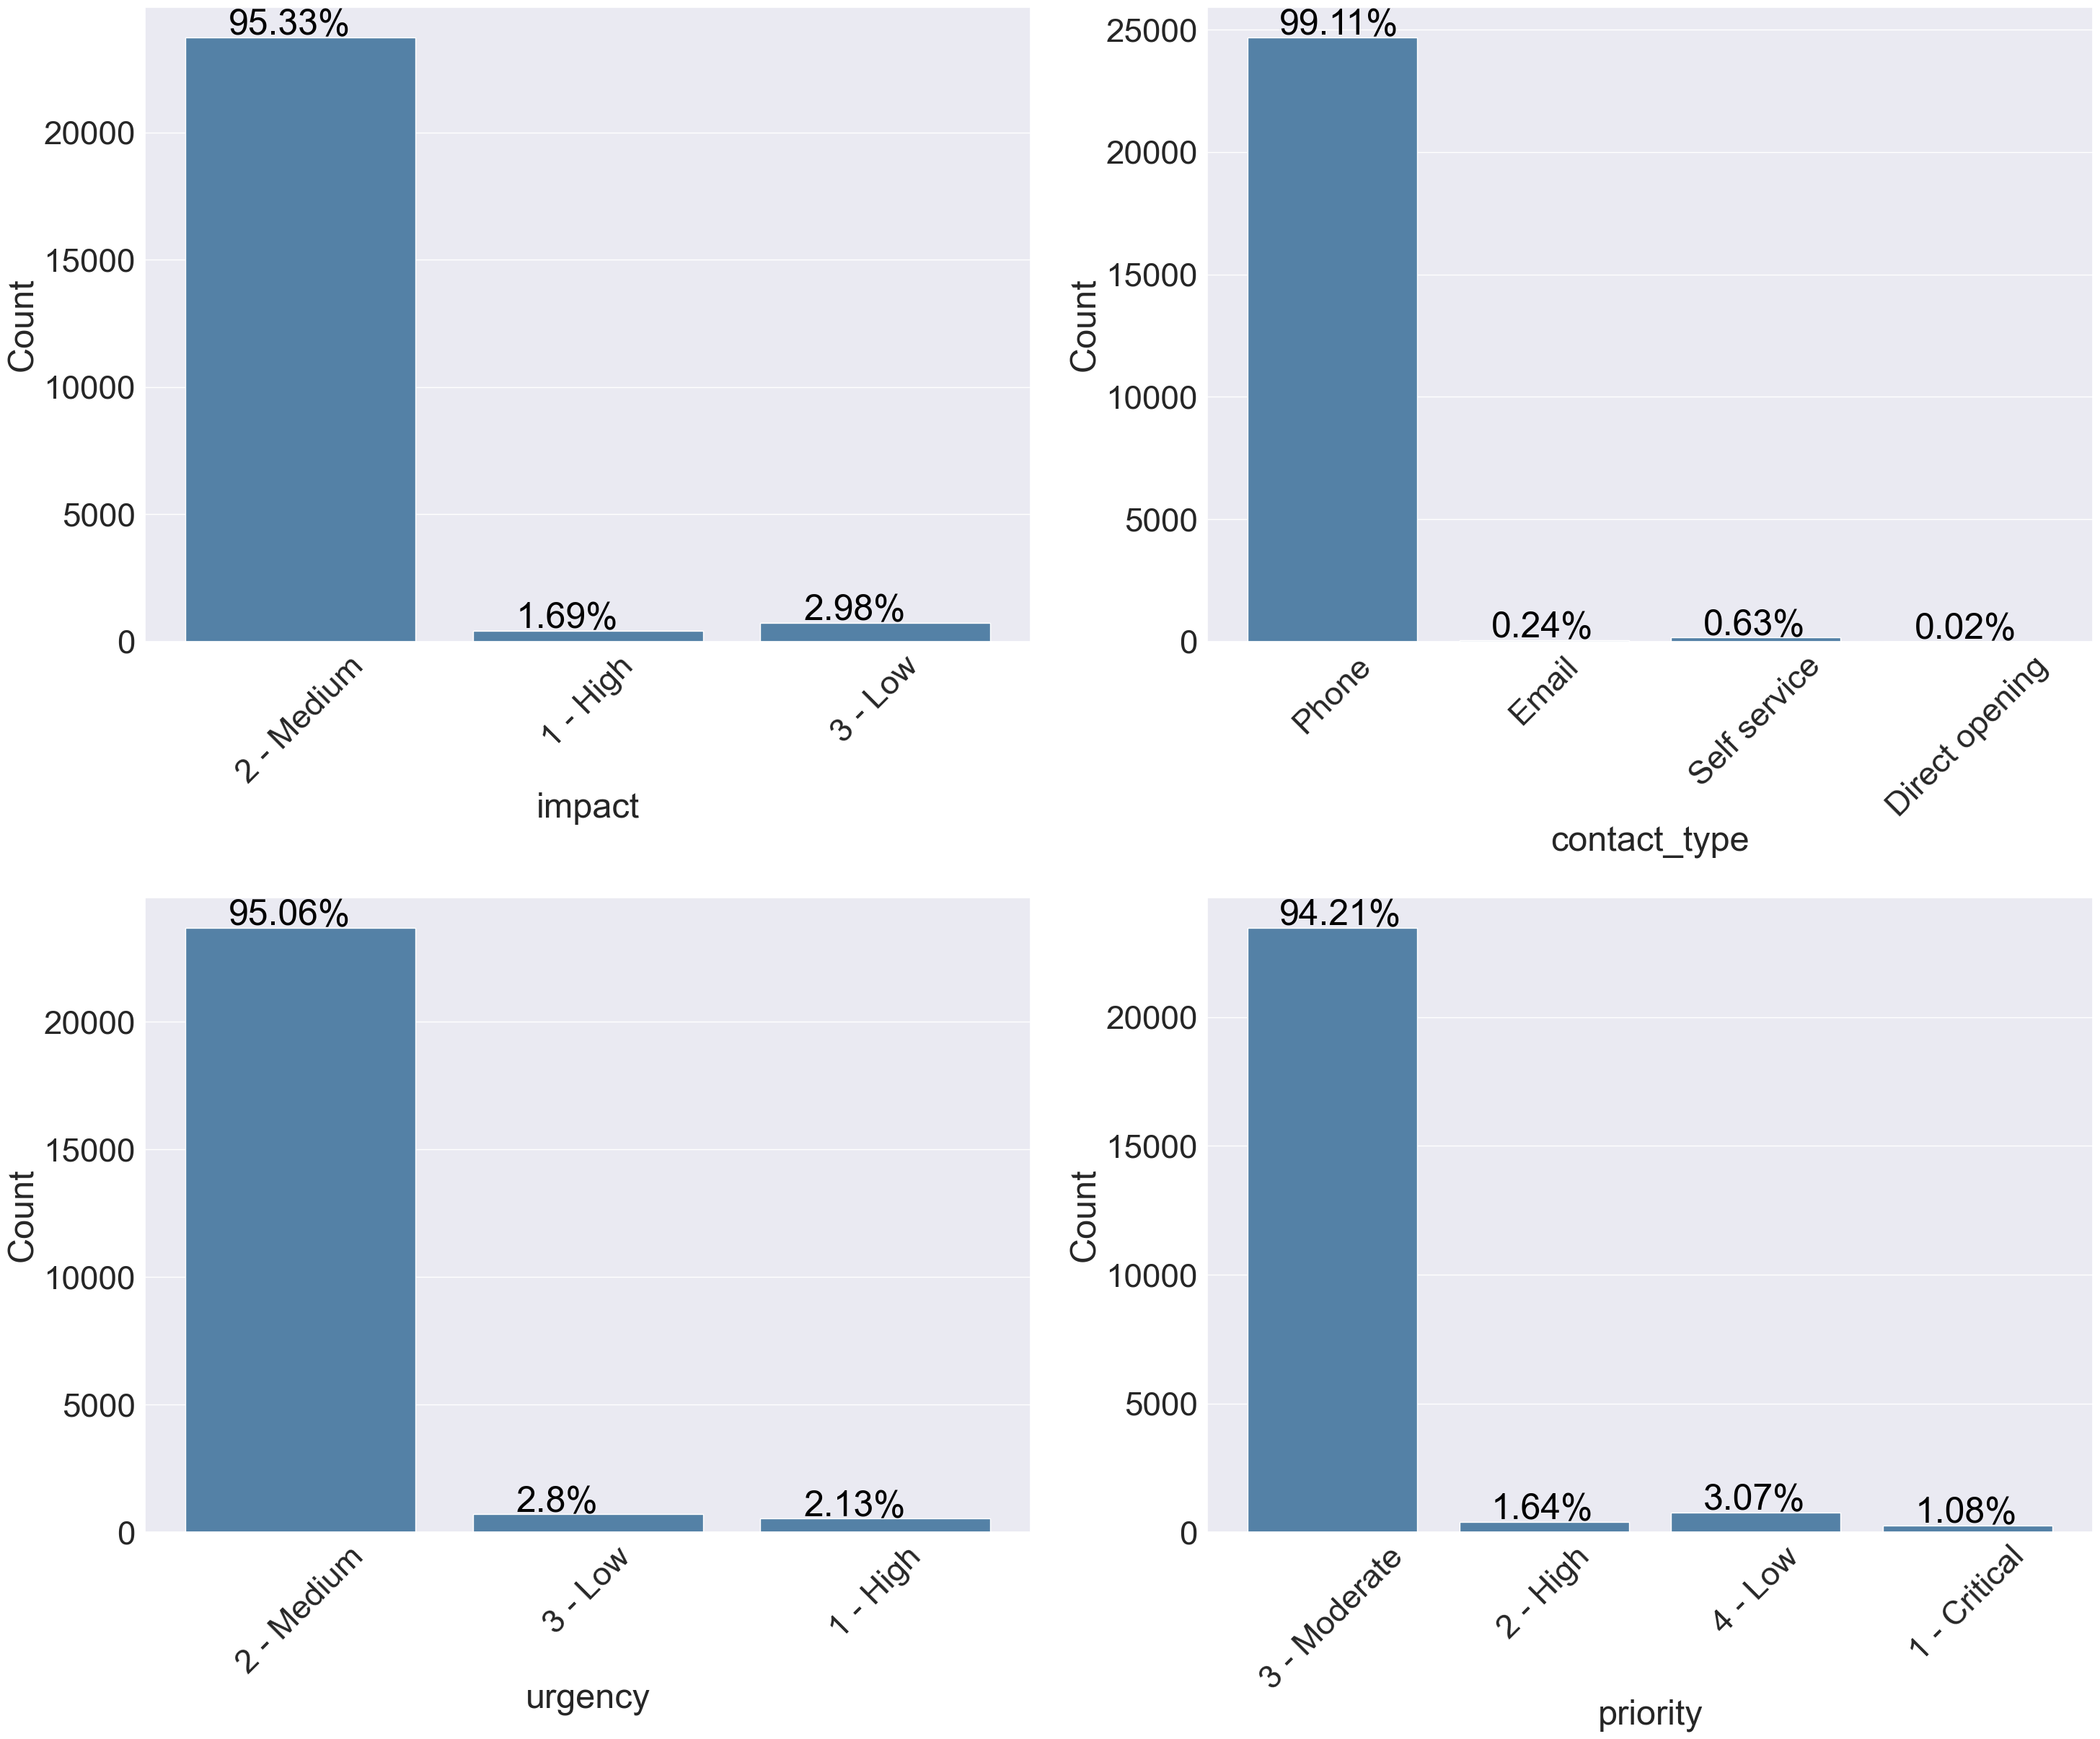

In [338]:
colname = ['impact','contact_type','urgency','priority']
order_list =[['1 - High','2 - Medium','3 - Low '],['Phone','Self service','Email','Direct opening '],['1 - High','2 - Medium','3 - Low '],['1 - Critical','2 - High','3 - Moderate','4 - Low']]


for i,j in enumerate(colname):
    plt.subplot(2,2,i+1)
    
    ax= sns.countplot(data = inc_closed, x = j,color= "steelblue") ##,order = order_list[i] (if this is added there is error)
    plt.ylabel("Count",fontsize=35)  
    plt.xlabel((j),fontsize=35) 
    plt.xticks(rotation=45)
   
    plt.margins(0.05)
    bar_perc(ax)

plt.tight_layout()

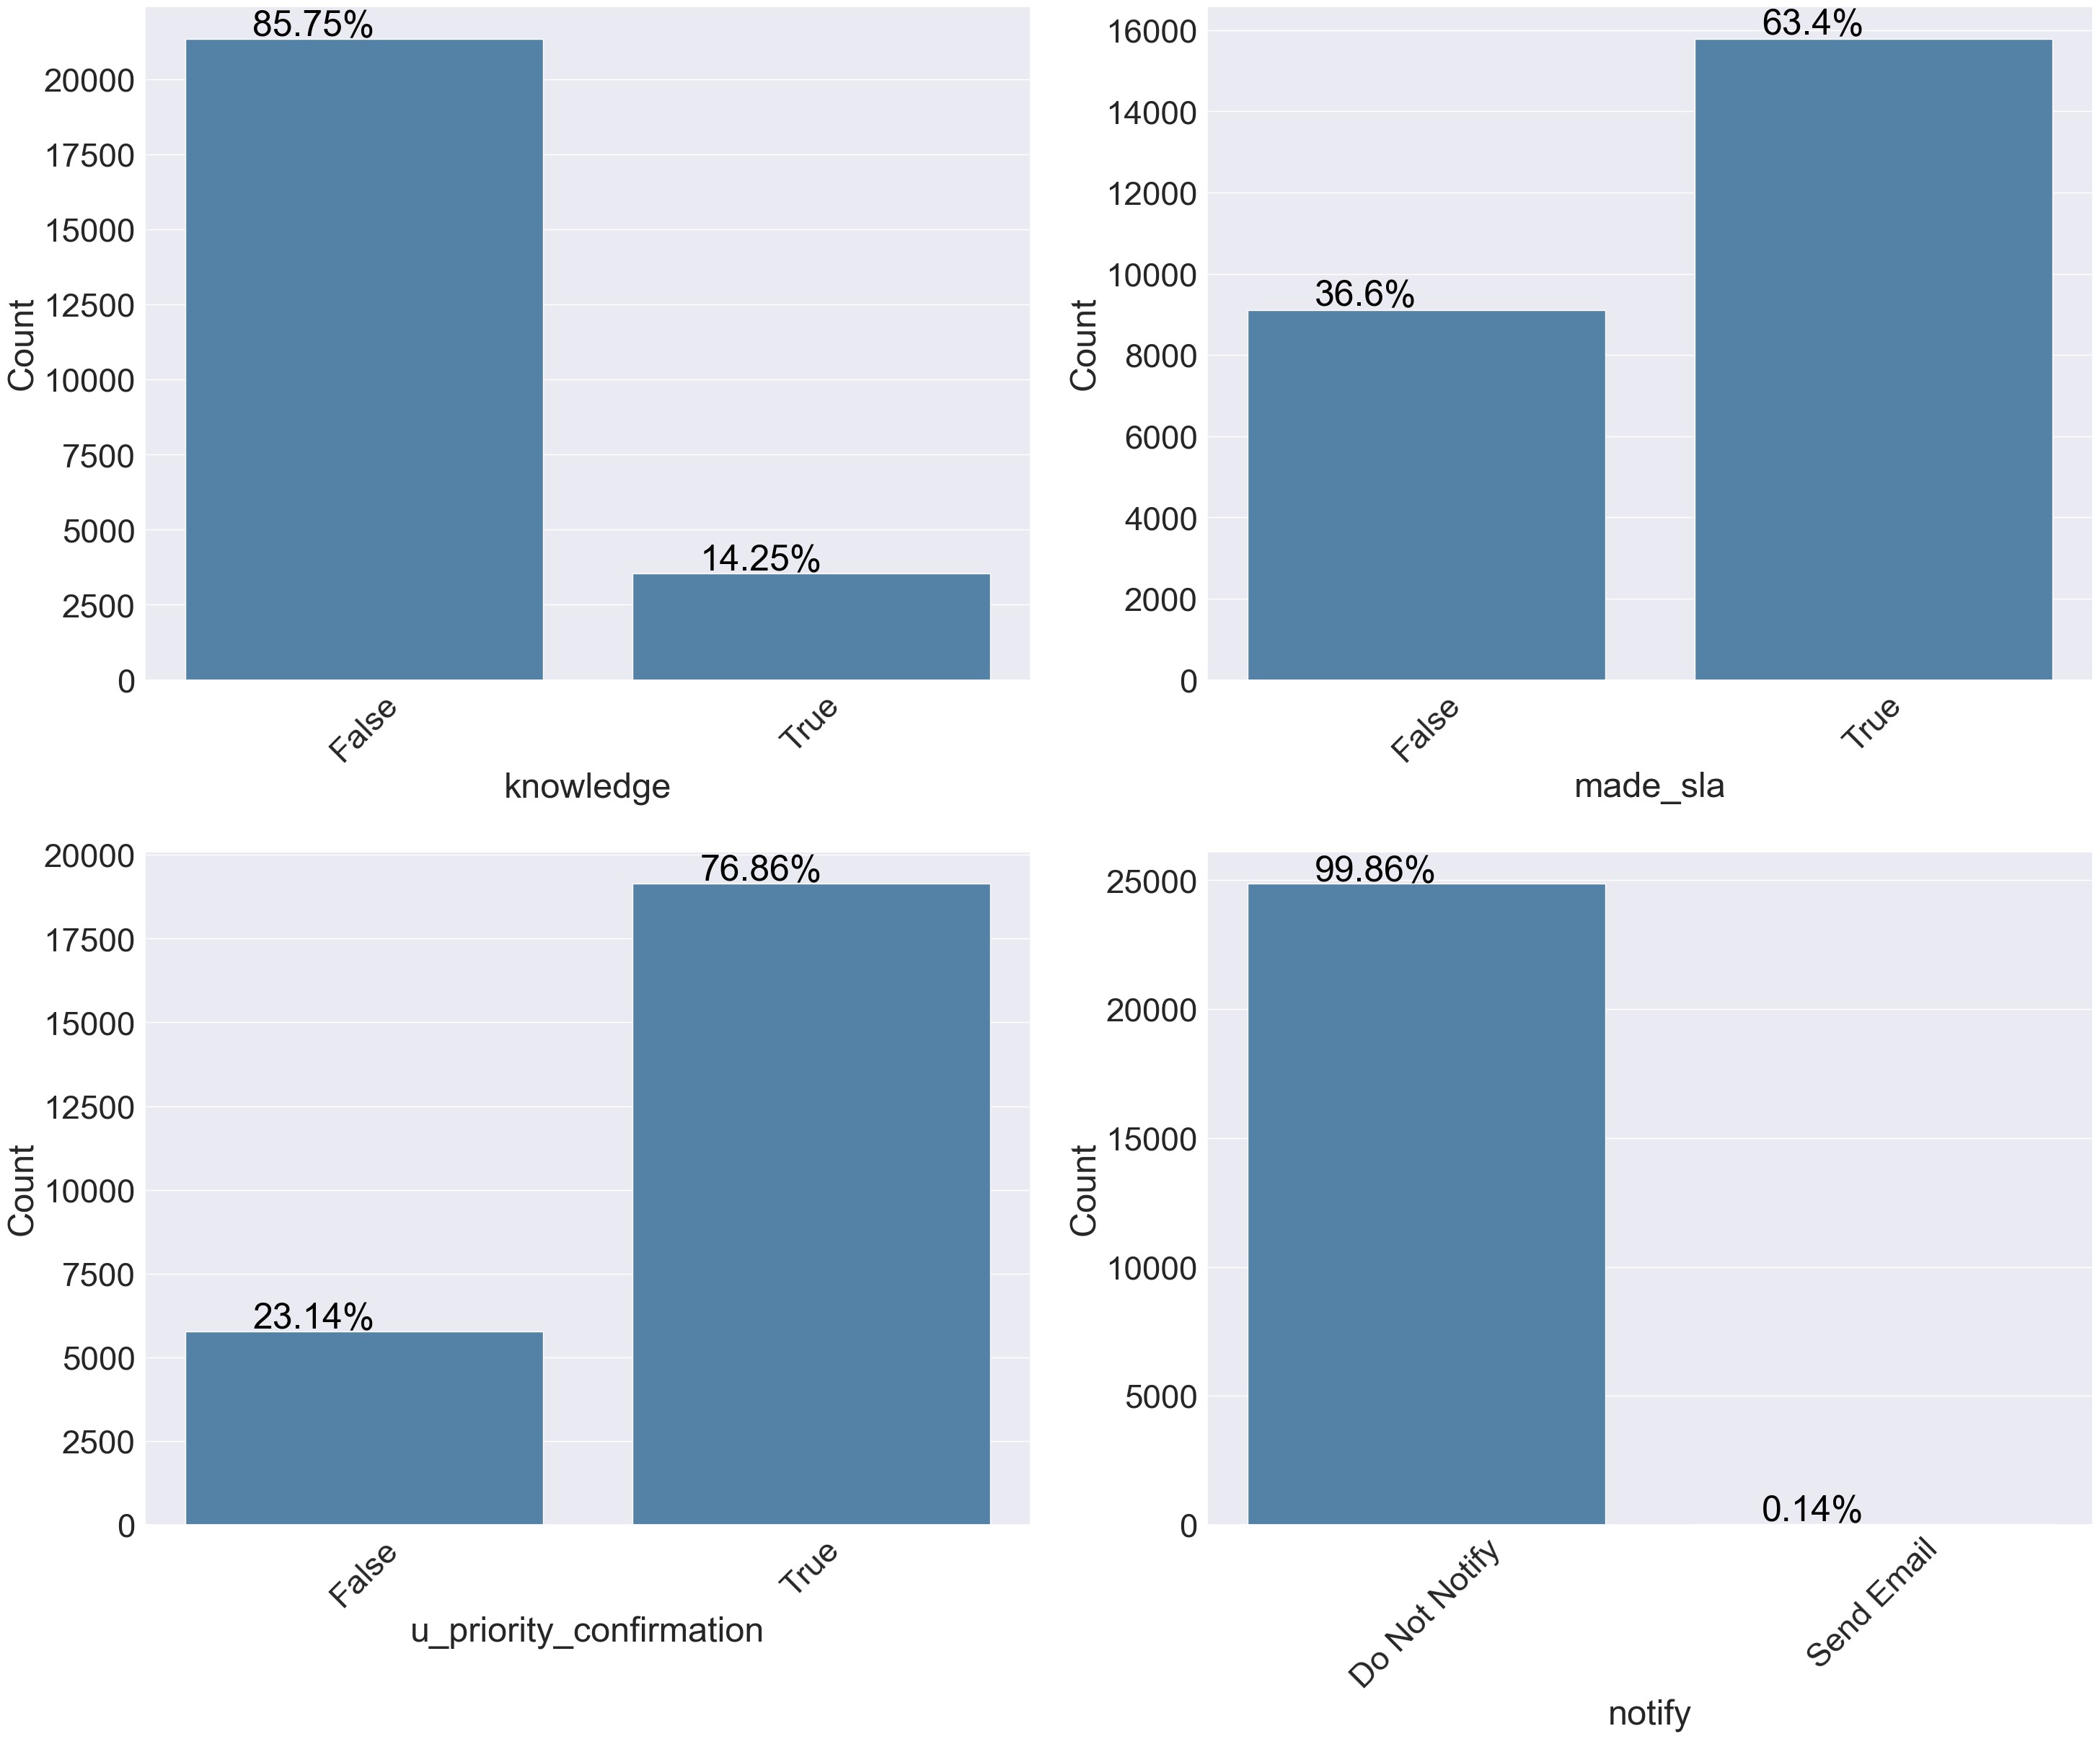

In [339]:
colname = ['knowledge','made_sla','u_priority_confirmation','notify']


for i,j in enumerate(colname):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(data = inc_closed, x = j,color= "steelblue")
    bar_perc(ax)
    plt.ylabel("Count",fontsize=35)  
    plt.xlabel((j),fontsize=35) 
    plt.xticks(rotation=45)
    
    plt.margins(0.05)

plt.tight_layout()



### Distribution of number of tickets opened every hour of the day.

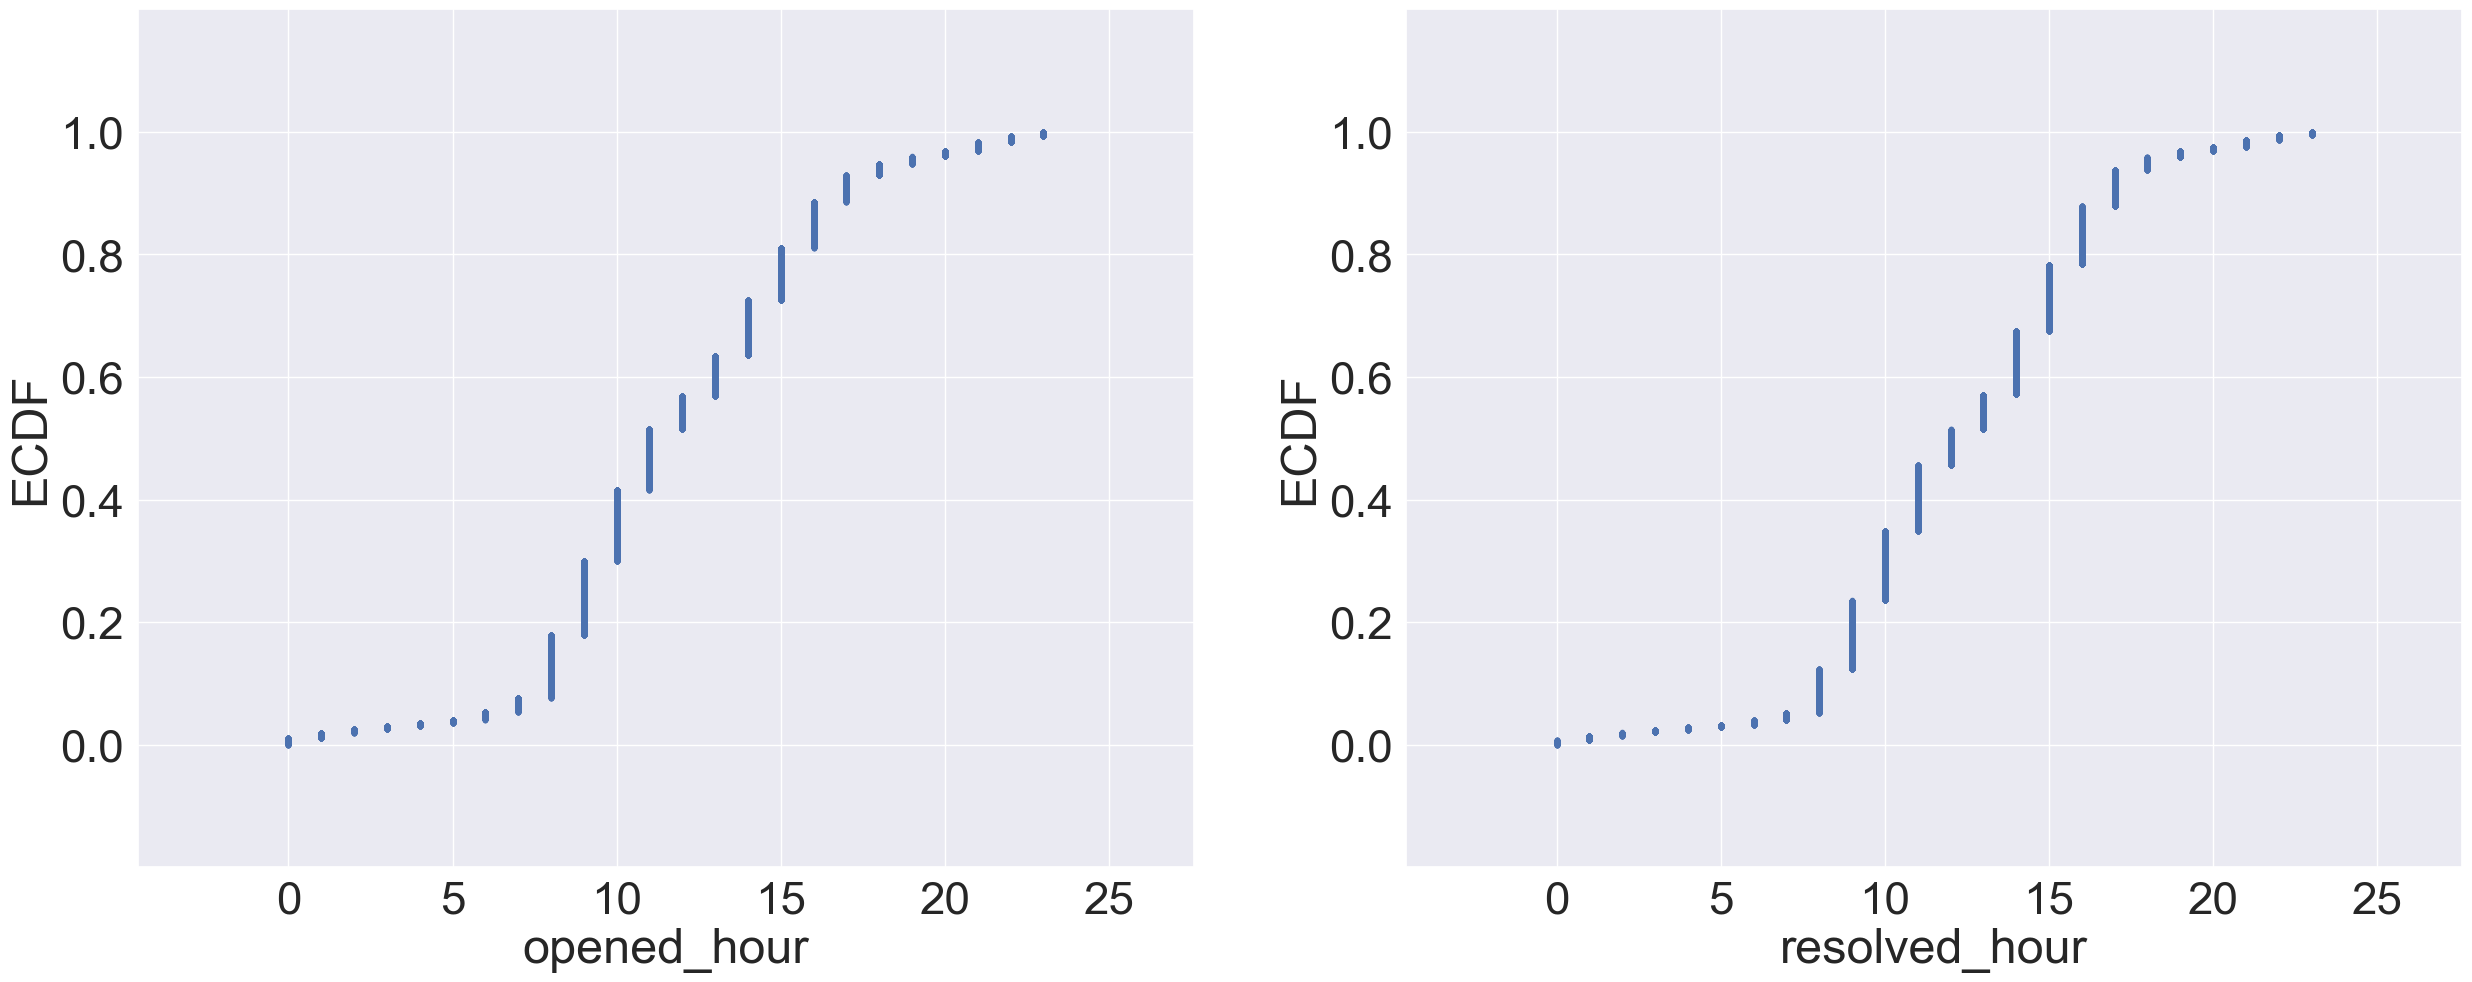

In [340]:
def ecdf(data):
    n= len(data)
    x = np.sort(data)
    y = np.arange(1,n+1) /n
    
    return x,y

def ecdf_plot(colname):
    for i,j in enumerate(colname):
        plt.subplot(2,2,i+1)
        x,y = ecdf(inc_closed[j])
        ax = plt.plot(x,y,marker='.',linestyle='none')
        plt.xlabel((j),fontsize=35)
        plt.ylabel("ECDF",fontsize=35)
        plt.margins(0.2)
        
        
inc_closed['opened_hour']= inc_closed.opened_at.dt.hour
inc_closed['resolved_hour']= inc_closed.resolved_at.dt.hour

colname =['opened_hour','resolved_hour']
ecdf_plot(colname)      

inc_closed = inc_closed.drop(['opened_hour','resolved_hour','opened_at','resolved_at'],axis=1)

As, seen in  first plot for opened_hour you can see that most of the ticket's almost 80% of it was opened after 1000hrs(10 AM) in the morning.

its similar in case of resolved_hours , most of the tickets are resolved after 10 

In [341]:
inc_closed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24902 entries, 0 to 24901
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   number                   24902 non-null  object
 1   incident_state           24902 non-null  object
 2   active                   24902 non-null  bool  
 3   reassignment_count       24902 non-null  int64 
 4   reopen_count             24902 non-null  int64 
 5   sys_mod_count            24902 non-null  int64 
 6   made_sla                 24902 non-null  bool  
 7   contact_type             24902 non-null  object
 8   location                 24902 non-null  object
 9   category                 24902 non-null  object
 10  subcategory              24902 non-null  object
 11  u_symptom                24902 non-null  object
 12  cmdb_ci                  24902 non-null  object
 13  impact                   24902 non-null  object
 14  urgency                  24902 non-nul

## Preprocessing Data

#### Below function can be used to convert all the catogrical features 

In [342]:
def label_conv(dataset):
    
    all_col = dataset.columns
    from sklearn.preprocessing import LabelEncoder
    lb_make = LabelEncoder()
    for x in all_col:
        if dataset[x].dtype == 'O':
            dataset[x] = dataset[x].astype(str)
            dataset[x] = lb_make.fit_transform(dataset[x])
    
            

In [343]:
label_conv(inc_closed)
inc_closed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24902 entries, 0 to 24901
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   number                   24902 non-null  int32
 1   incident_state           24902 non-null  int32
 2   active                   24902 non-null  bool 
 3   reassignment_count       24902 non-null  int64
 4   reopen_count             24902 non-null  int64
 5   sys_mod_count            24902 non-null  int64
 6   made_sla                 24902 non-null  bool 
 7   contact_type             24902 non-null  int32
 8   location                 24902 non-null  int32
 9   category                 24902 non-null  int32
 10  subcategory              24902 non-null  int32
 11  u_symptom                24902 non-null  int32
 12  cmdb_ci                  24902 non-null  int32
 13  impact                   24902 non-null  int32
 14  urgency                  24902 non-null  int32
 15  pr

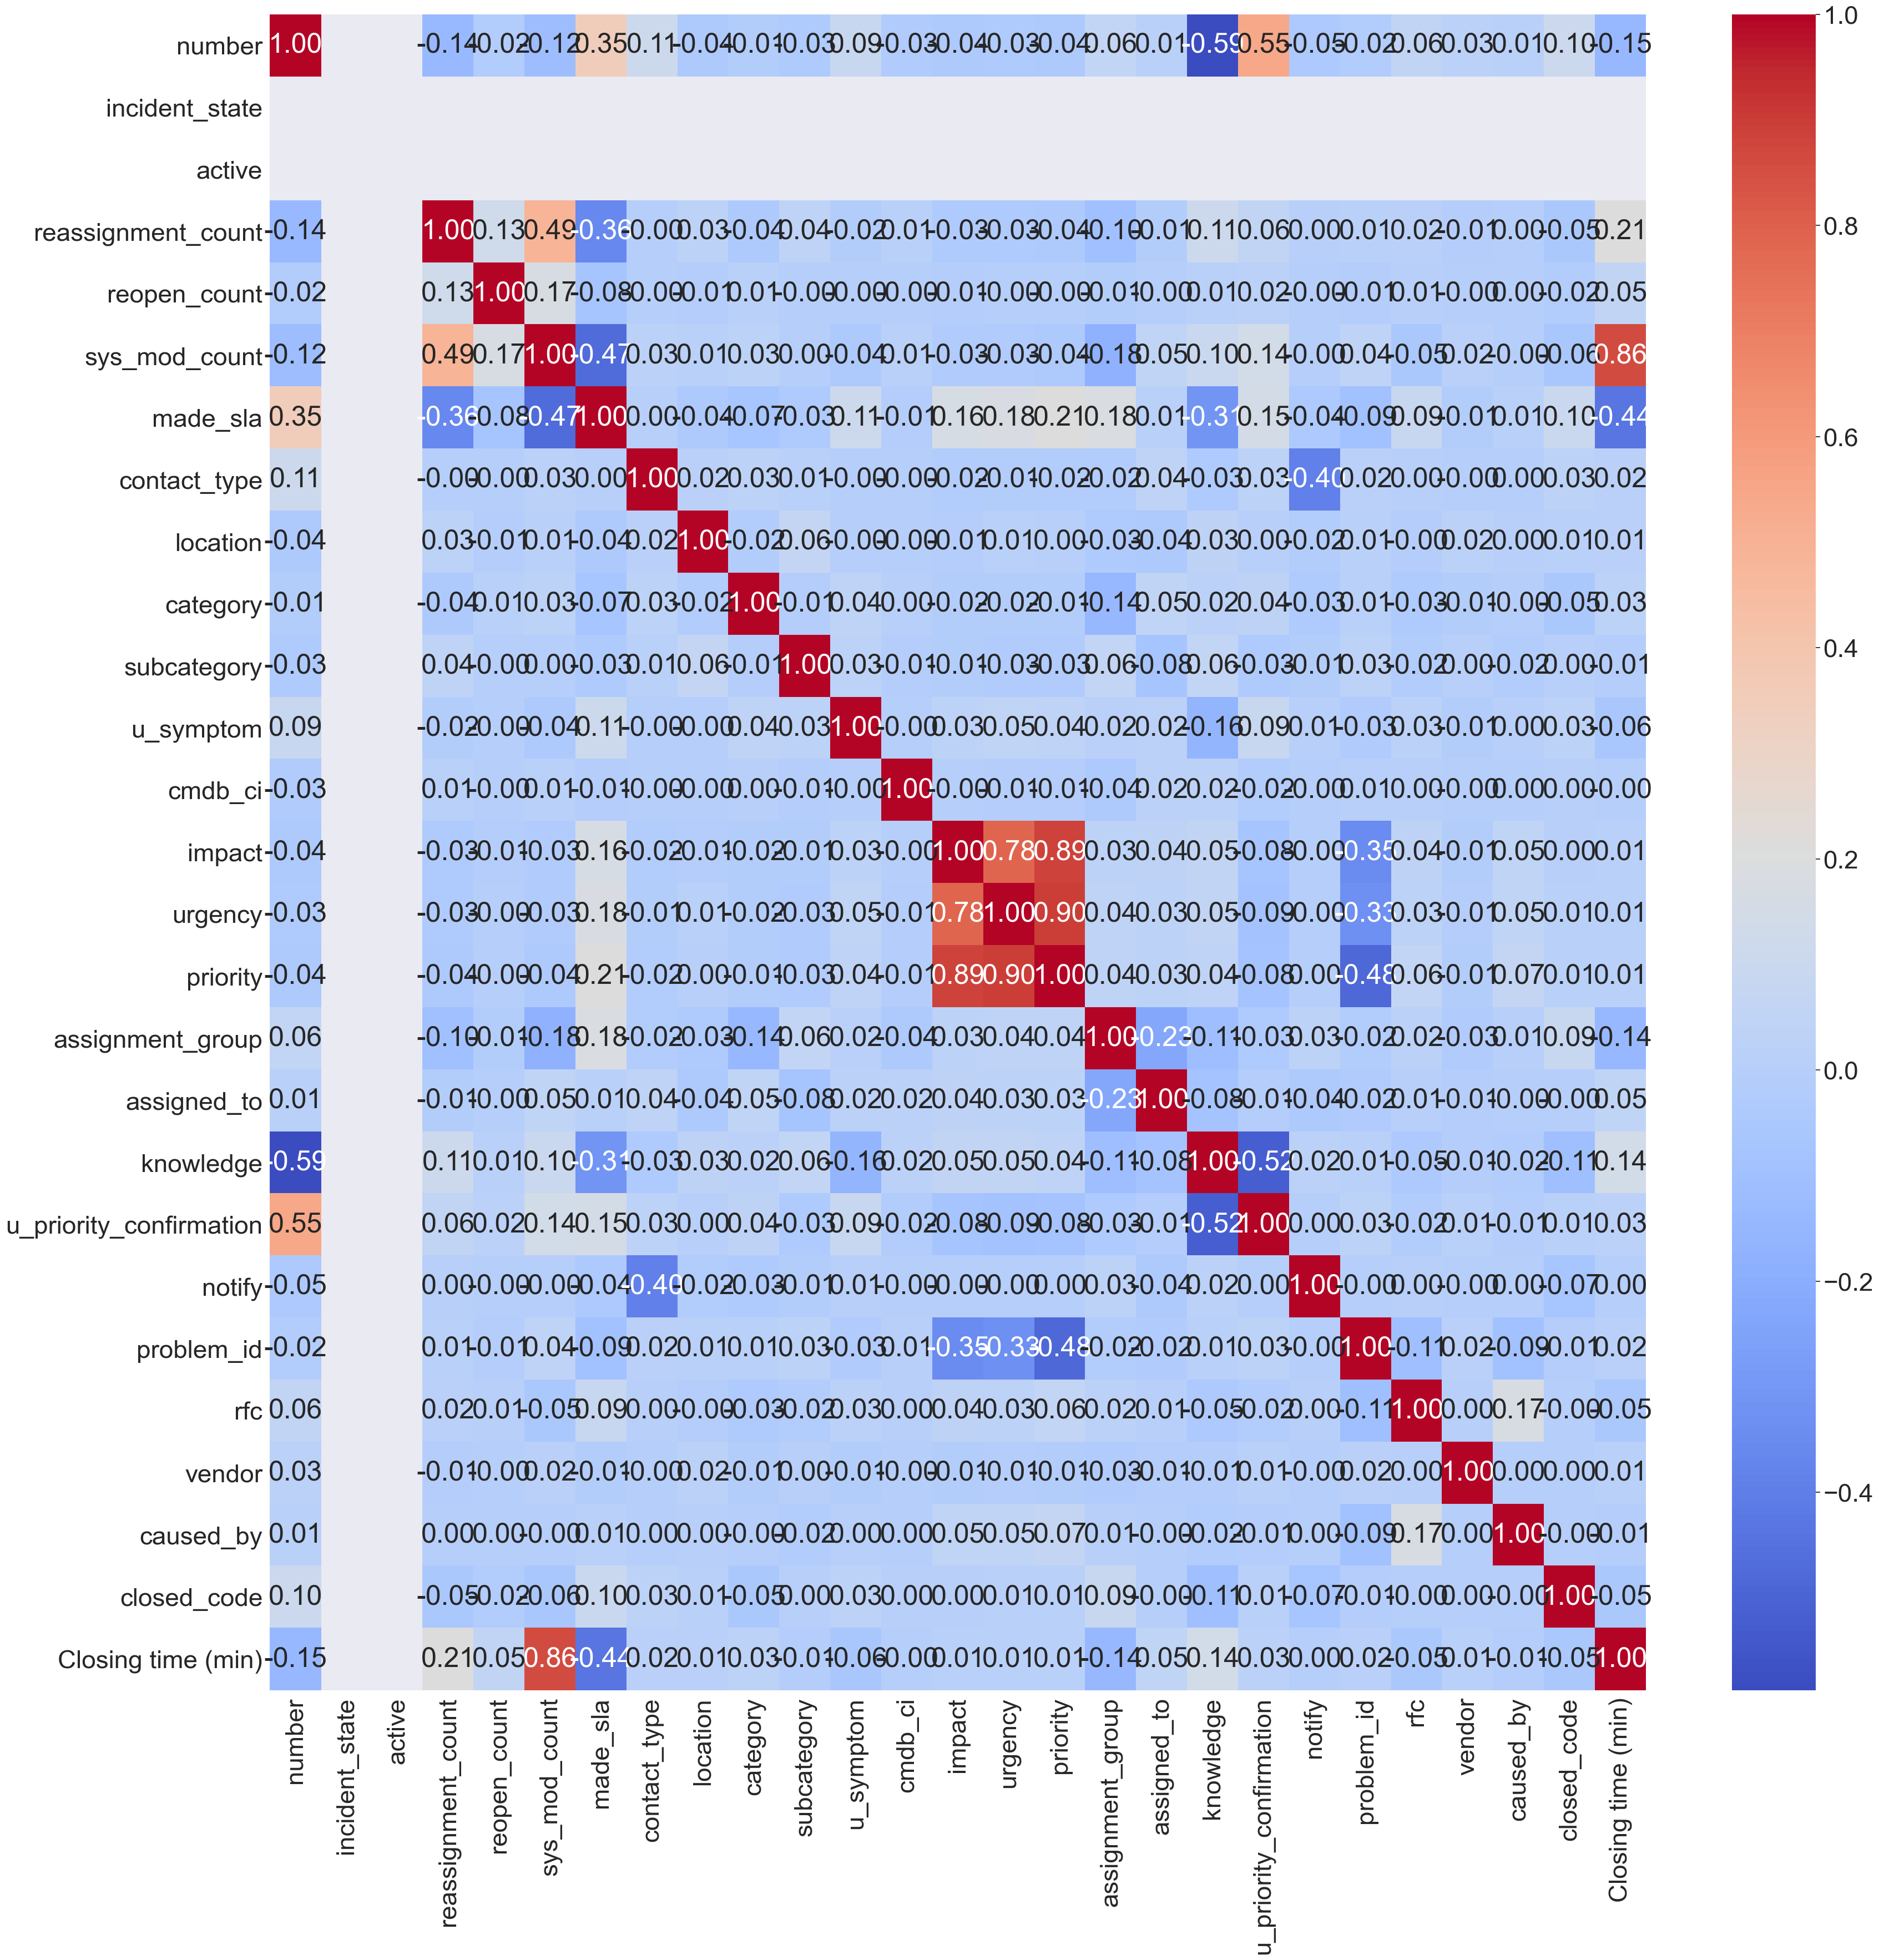

In [344]:
g = sns.heatmap(inc_closed.corr(),annot=True,fmt = ".2f", cmap = "coolwarm")
fig=plt.gcf()
fig.set_size_inches(40,40)
plt.show()

In [348]:
inc_closed1 = inc_closed.drop(['incident_state','active'],axis=1)

In [349]:
X_all = inc_closed1.drop(["Closing time (min)"], axis = 1)
y_all = inc_closed1["Closing time (min)"]
from sklearn.model_selection import train_test_split
X_train_first, X_hold, y_train_first, y_hold = train_test_split(X_all, y_all,test_size=0.2,random_state = 42)

## Machine Learning

In [350]:
X = X_train_first
y = y_train_first
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state = 42)

In [351]:
inc_closed.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,Closing time (min)
0,0,0,False,0,0,4,True,2,43,40,67,381,0,1,1,2,43,0,True,False,0,0,174,0,3,13,7844
1,1,0,False,1,0,8,True,2,62,26,109,254,0,1,1,2,13,210,True,False,0,0,174,0,3,13,8960
2,2,0,False,0,0,6,True,2,104,8,25,254,0,1,1,2,59,186,True,False,0,107,174,0,3,2,8450
3,3,0,False,0,0,3,True,2,104,51,244,235,0,1,1,2,14,27,True,False,0,0,174,0,3,11,10462
4,4,0,False,1,0,7,False,2,216,38,64,74,0,0,1,1,12,0,True,False,0,0,174,0,3,15,7742


## GradientBoosting

In [352]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score


gradient = GradientBoostingRegressor()


In [353]:
score = cross_val_score(gradient,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.88443003 0.93202229 0.85444903 0.83668557 0.90376409]
Average cross-validation score: 0.8823


# Random Forest

In [354]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
hyperparametres = { 'n_estimators':20 }
regressor = RandomForestRegressor(**hyperparametres)
regressor.fit(X_train,y_train)
score=regressor.score(X_test,y_test)
score

0.8944328728505173

In [355]:
hyperparametres = { 'n_estimators':20 }
regressor = RandomForestRegressor(**hyperparametres)
score = cross_val_score(regressor,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.91627819 0.92478926 0.84970013 0.83399675 0.91535261]
Average cross-validation score: 0.8880


## Linear Regression

In [356]:

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
score = regressor.score(X_test, y_test)
score

0.8159453335839879

In [357]:
regressor = LinearRegression()
score = cross_val_score(regressor,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.83873091 0.87177615 0.78254309 0.78088711 0.83858724]
Average cross-validation score: 0.8225


## KNN Neighbor

In [358]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10,metric='euclidean') # Maximum accuracy for n=10
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.0058557804918855615

In [359]:
knn = KNeighborsClassifier(n_neighbors=12,metric='euclidean')
score = cross_val_score(knn,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

C:\Users\Rahul KG\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Cross-validation scores: [0.00250986 0.00394407 0.00286841 0.00537827 0.00430416]
Average cross-validation score: 0.0038


## LASSO

In [360]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 10)
lasso.fit(X_train,y_train)
print('Train score: {:.4f}'.format(lasso.score(X_train,y_train)))
print('Test score: {:.4f}'.format(lasso.score(X_test, y_test)))

Train score: 0.8244
Test score: 0.8159


In [361]:
lasso = Lasso(alpha = 10)
score = cross_val_score(lasso,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.83870948 0.87124949 0.78241121 0.78078581 0.83899494]
Average cross-validation score: 0.8224


#   <center>Predicting time left to solve the ticket</center>

In [362]:
inc_eventdf1 = inc_eventdf.drop(['opened_at','resolved_at','incident_state','active'],axis=1)

In [363]:
label_conv(inc_eventdf1)

In [364]:
X_all_second = inc_eventdf1.drop(["time_elapsed"], axis = 1)
y_all_second = inc_eventdf1["time_elapsed"]
from sklearn.model_selection import train_test_split
X_train_second, X_hold_second, y_train_second, y_hold_second = train_test_split(X_all_second, y_all_second,test_size=0.2,random_state = 42)

In [365]:
X = X_train_second
y = y_train_second
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state = 42)

In [366]:
inc_eventdf1.head()

,number,reassignment_count,reopen_count,sys_mod_count,made_sla,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,time_elapsed
0,0,0,0,0,True,2,43,45,70,502,0,1,1,2,47,0,True,False,0,0,181,0,3,13,7837
1,0,0,0,2,True,2,43,45,70,502,0,1,1,2,47,0,True,False,0,0,181,0,3,13,7387
2,0,0,0,3,True,2,43,45,70,502,0,1,1,2,47,0,True,False,0,0,181,0,3,13,7231
3,0,0,0,4,True,2,43,45,70,502,0,1,1,2,47,0,True,False,0,0,181,0,3,13,0
4,1,0,0,0,True,2,62,29,113,353,0,1,1,2,63,224,True,False,0,0,181,0,3,13,8943


## GradientBoosting

In [367]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score


gradient = GradientBoostingRegressor()


In [368]:
score = cross_val_score(gradient,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.24874049 0.2391707  0.21284075 0.24501461 0.25737107]
Average cross-validation score: 0.2406


## Random Forest

In [369]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
hyperparametres = { 'n_estimators':20 }
regressor = RandomForestRegressor(**hyperparametres)
regressor.fit(X_train,y_train)
score=regressor.score(X_test,y_test)
score

0.6017224366596298

In [370]:
hyperparametres = { 'n_estimators':20 }
regressor = RandomForestRegressor(**hyperparametres)
score = cross_val_score(regressor,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.56481387 0.59399138 0.57547288 0.57739216 0.54218474]
Average cross-validation score: 0.5708


## Linear Regression 

In [371]:

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
score = regressor.score(X_test, y_test)
score

0.08782711644789964

In [372]:
regressor = LinearRegression()
score = cross_val_score(regressor,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.08672171 0.08656186 0.08222398 0.08054098 0.08314929]
Average cross-validation score: 0.0838


## KNN Neighbor

In [373]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10,metric='euclidean') # Maximum accuracy for n=10
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.13080181187128653

In [374]:
knn = KNeighborsClassifier(n_neighbors=12,metric='euclidean')
score = cross_val_score(knn,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

C:\Users\Rahul KG\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Cross-validation scores: [0.14263204 0.14061515 0.13853523 0.14093917 0.13961551]
Average cross-validation score: 0.1405


## LASSO

In [375]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 10)
lasso.fit(X_train,y_train)
print('Train score: {:.4f}'.format(lasso.score(X_train,y_train)))
print('Test score: {:.4f}'.format(lasso.score(X_test, y_test)))

Train score: 0.0846
Test score: 0.0878


In [376]:
lasso = Lasso(alpha = 10)
score = cross_val_score(lasso,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.08657309 0.0866481  0.08214487 0.08055843 0.08327087]
Average cross-validation score: 0.0838
